# Information Theory in Deep Architectures for Concept Detection and Explainable AI

This notebook demonstrates how to apply model interpretability algorithms on pretrained VGG-16 model using a handpicked image and visualizes the attributions for each pixel by overlaying them on the image.

Captum library privides function of Layer Conductance, that helps to evaluate importance of each neuron within a given Layer

In [ ]:
pip install captum

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 15.3 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn.functional as F

from PIL import Image

import os
import json
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt

import torchvision
from torchvision import models
from torchvision import transforms

from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

## 1- Loading the model and the dataset


Loads pretrained Resnet model and sets it to eval mode

In [ ]:
model = models.vgg16(pretrained=True)
model = model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 153MB/s]


In [ ]:
model.features[0]

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [ ]:
!wget -P $HOME/.torch/models https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json

--2023-12-19 20:48:44--  https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.90.198, 52.216.90.70, 16.182.40.88, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.90.198|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35363 (35K) [application/octet-stream]
Saving to: ‘/root/.torch/models/imagenet_class_index.json’

imagenet_class_inde 100%[===================>]  34.53K  --.-KB/s    in 0.002s  

2023-12-19 20:48:44 (15.1 MB/s) - ‘/root/.torch/models/imagenet_class_index.json’ saved [35363/35363]



In [ ]:
labels_path = os.getenv("HOME") + '/.torch/models/imagenet_class_index.json'
with open(labels_path) as json_data:
    idx_to_labels = json.load(json_data)

Defines transformers and normalizing functions for the image.
It also loads an image from the `img/resnet/` folder that will be used for interpretation purposes.

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


transform_normalize = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

img = Image.open('/content/animal_2.jpg')

transformed_img = transform(img)

input = transform_normalize(transformed_img)
input = input.unsqueeze(0)

Predict the class of the input image

In [ ]:
model.features[2]

Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [ ]:
model.classifier[3]

Linear(in_features=4096, out_features=4096, bias=True)

## Layers of VGG-16

In [ ]:
layer_conv_1=model.features[0]
layer_conv_2=model.features[2]
layer_conv_3=model.features[5]
layer_conv_4=model.features[7]
layer_conv_5=model.features[10]
layer_conv_6=model.features[12]
layer_conv_7=model.features[14]
layer_conv_8=model.features[17]
layer_conv_9=model.features[19]
layer_conv_10=model.features[21]
layer_conv_11=model.features[24]
layer_conv_12=model.features[26]
layer_conv_13=model.features[28]
layer_conv_14=model.classifier[0]
layer_conv_15=model.classifier[3]
layer_conv_16=model.classifier[6]

## 2- Layer Conductance

In [ ]:
from captum.attr import LayerConductance

Flatten all vectors of Layer Conductance for each Convolutional Layer

In [ ]:
layer=layer_conv_13
cond =LayerConductance(model,layer)
cond_vals = cond.attribute(input,target=291)
cond_vals = cond_vals.detach().numpy()
p=cond_vals.shape[1]
q=cond_vals.shape[2]*cond_vals.shape[3]
cond_vals_flatten_conv13=cond_vals.reshape((p,q))

Transormation for Flatten Layers

In [ ]:
layer=layer_conv_16
cond =LayerConductance(model,layer)
cond_vals = cond.attribute(input,target=291)
cond_vals = cond_vals.detach().numpy()
cond_vals_flatten_conv16=np.transpose(cond_vals)

In [ ]:
cond_vals_flatten_conv1.shape

(64, 375200)

Visualize Conductances per Layer

In [ ]:
# Helper method to print importances and visualize distribution
def visualize_importances(feature_names, importances, title="Average Feature Importances", plot=True, axis_title="Features"):
    print(title)
    for i in range(len(feature_names)):
        print(feature_names[i], ": ", '%.4f'%(importances[i]))
    x_pos = (np.arange(len(feature_names)))
    if plot:
        plt.figure(figsize=(12,6))
        cmap = plt.get_cmap('copper')
        norm = plt.Normalize(importances.min(), importances.max())
        colors = cmap(norm(importances))
        plt.bar(x_pos, importances, align='center',color=colors)
        plt.xticks(x_pos, feature_names, wrap=True)
        plt.xlabel(axis_title)
        plt.title(title)


In [ ]:
visualize_importances(range(1000),np.mean(cond_vals_flatten_conv16, axis=1),title="Average Neuron Importances", axis_title="Neurons")

Dispersion

In [ ]:
dispersion=np.std(cond_vals_flatten_conv16)/np.mean(cond_vals_flatten_conv16)
print(dispersion)

31.606956


## 3- Enropy of Layer Conductance Flatten

In [ ]:
import numpy as np

def entropy_continuous(data, bins=10):
    # Create histogram
    counts, bin_edges = np.histogram(data, bins=bins, density=True)

    # Calculate the probabilities
    probabilities = counts * np.diff(bin_edges)

    # Remove zero probabilities
    probabilities = probabilities[probabilities > 0]

    # Calculate the entropy using the formula
    entropy = -np.sum(probabilities * np.log2(probabilities))

    return entropy

# Example usage:
data_continuous = np.random.randn(1000)  # Replace this with your continuous data
result_continuous = entropy_continuous(data_continuous)
print(f"Entropy: {result_continuous}")


Entropy: 2.631988182247095


In [ ]:
entropy_continuous(cond_vals_flatten_conv7,40)

0.04025529910013057

In [ ]:
mean_entropy=[]

In [ ]:
var=[]
for j in range (1,100):
  var.append(entropy_continuous(cond_vals_flatten_conv16,j))


In [ ]:
# Mean of entropies
mean_entropy.append(np.mean(var))

In [ ]:
mean_entropy

[0.19678918279444485,
 0.1693082101043546,
 0.19823718158497505,
 0.10566876720124287,
 0.2094204496626985,
 0.17239339805465534,
 0.06939896281875221,
 0.09181186043840715,
 0.18325693389578734,
 0.08155338051772758,
 0.4932494293555213,
 0.44676680025322035,
 0.14074835884505144,
 2.006228983686914,
 2.0940402972432124,
 0.011292527861325188]

In [ ]:
len(var)

99

In [ ]:
entropy=var

In [ ]:
entropy=np.row_stack((entropy,var))

In [ ]:
entropy.shape

(13, 99)

In [ ]:
####################################################################

## 4- Plot Entropy of Layers

Define Plot Function

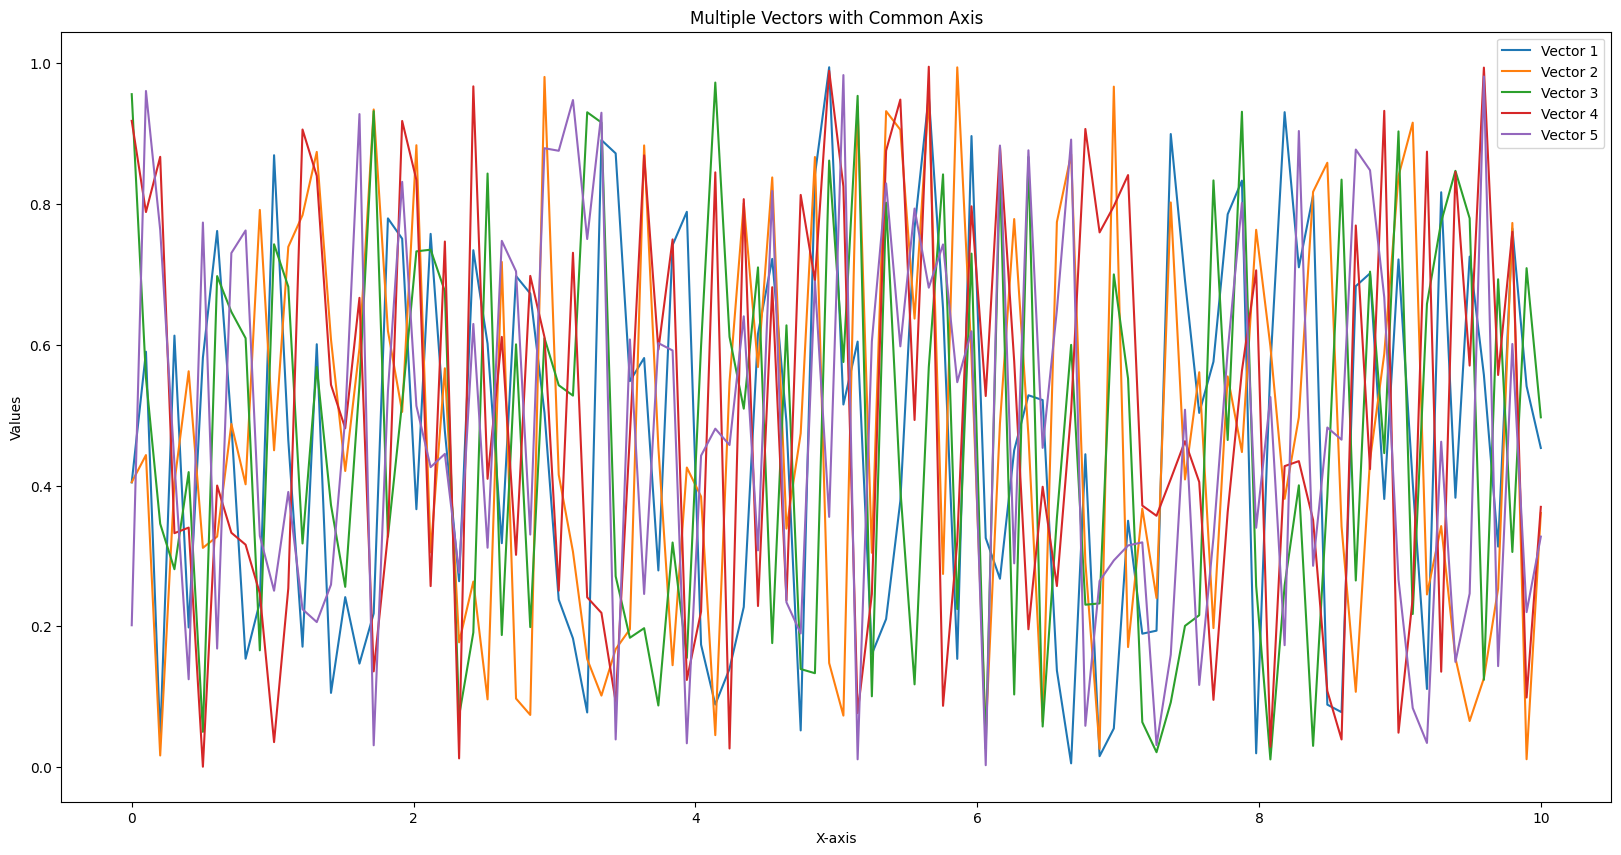

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Number of vectors
num_vectors = 5

# Generate some example data
x = np.linspace(0, 10, 100)  # Common x-axis values

# Generate random vectors for demonstration
vectors = np.random.rand(num_vectors, 100)

# Plotting each vector
fig, ax = plt.subplots(figsize=(20,10))
for i in range(num_vectors):
    plt.plot(x, vectors[i], label=f'Vector {i + 1}')

# Adding labels and

plt.xlabel('X-axis')
plt.ylabel('Values')
plt.title('Multiple Vectors with Common Axis')

# Adding legend
plt.legend()

# Show the plot
plt.show()


In [ ]:
vectors.shape

(5, 100)

Plot Entropy

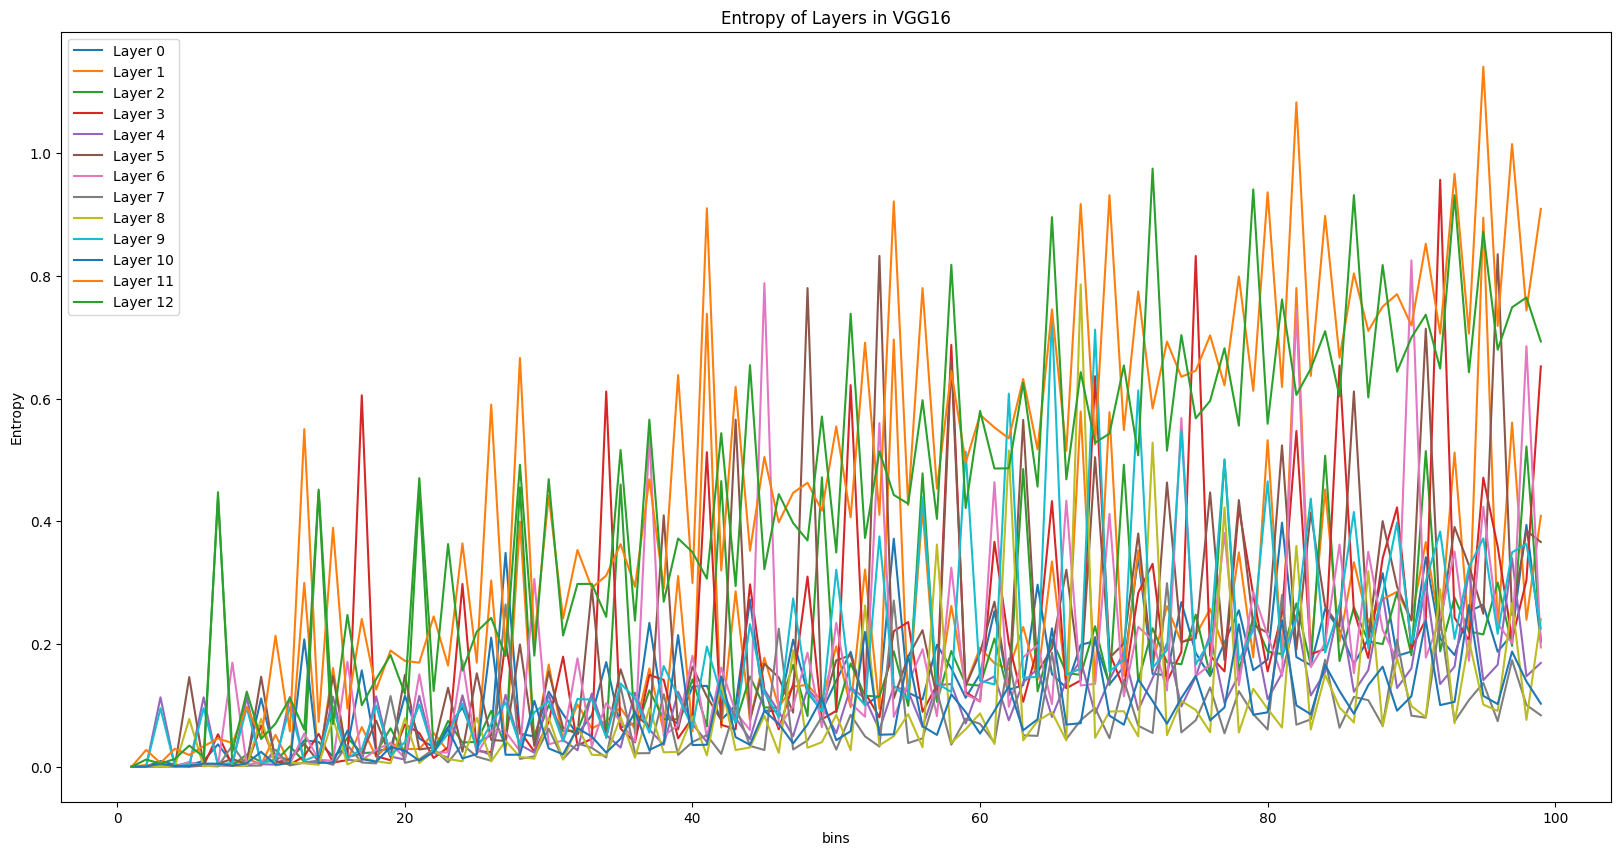

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Number of vectors
num_vectors = 13

# Generate some example data
x=np.arange(1,100) # Common x-axis values


# Plotting each vector
fig, ax = plt.subplots(figsize=(20,10))
for i in range(num_vectors):
    plt.plot(x, entropy[i-1], label=f'Layer {i}')

# Adding labels and

plt.xlabel('bins')
plt.ylabel('Entropy')
plt.title('Entropy of Layers in VGG16')

# Adding legend
plt.legend()

# Show the plot
plt.show()

## 5- Entropy by Layer: bins=10

In [ ]:
entropy_bins_10=entropy_continuous(cond_vals_flatten_conv1,10)

In [ ]:
entropy_bins_10=np.row_stack((entropy_bins_10,entropy_continuous(cond_vals_flatten_conv13,10)))

In [ ]:
entropy_bins_10[1]

array([0.00808891])

Text(0.5, 1.0, 'Entropy of Layers in VGG16')

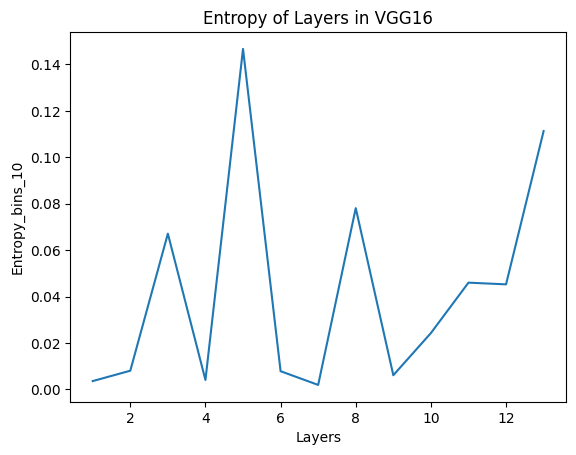

In [ ]:
fig = plt.figure()
ax = plt.axes()

x = np.linspace(1, 13, 13)
ax.plot(x, entropy_bins_10);
# Adding labels and

plt.xlabel('Layers')
plt.ylabel('Entropy_bins_10')
plt.title('Entropy of Layers in VGG16')

## 6- Entropy by Layer: bins=40

In [ ]:
entropy_bins_40=entropy_continuous(cond_vals_flatten_conv1,40)

In [ ]:
entropy_bins_40=np.row_stack((entropy_bins_40,entropy_continuous(cond_vals_flatten_conv13,40)))

Text(0.5, 1.0, 'Entropy of Layers in VGG16')

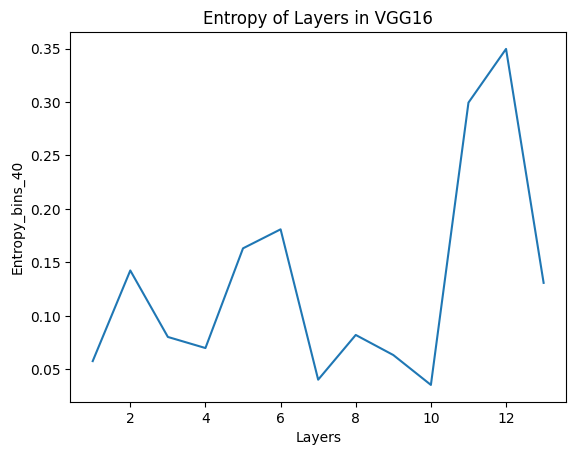

In [ ]:
fig = plt.figure()
ax = plt.axes()

x = np.linspace(1, 13, 13)
ax.plot(x, entropy_bins_40);
# Adding labels and

plt.xlabel('Layers')
plt.ylabel('Entropy_bins_40')
plt.title('Entropy of Layers in VGG16')

## 7- Mean of entropies per Layer

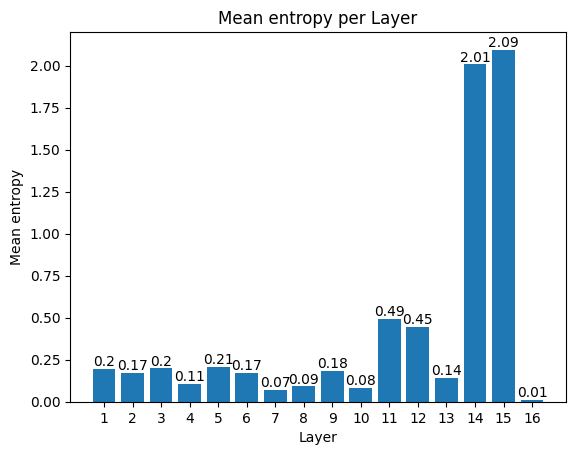

In [ ]:

# Create a bar plot
bars = plt.bar(range(len(mean_entropy)), mean_entropy)

# Add labels and title
plt.xlabel('Layer')
plt.ylabel('Mean entropy')
plt.title('Mean entropy per Layer')

# Set the x-axis ticks and labels to show all values
plt.xticks(range(len(mean_entropy)), range(1, len(mean_entropy) + 1))

# Add values on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

# Show the plot
plt.show()
